In [21]:
import numpy as np
from math import factorial
import cupy as cp
import matplotlib.pyplot as plt
import time

In [22]:
'Salvitzy-Golay Filter in CPU'

def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    
    
    try:
        window_size = np.abs(int(window_size))
        order = np.abs(int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    
    b = np.array([[k**i for i in order_range] for k in range(-half_window, half_window+1)])

    m1 = np.linalg.pinv(b)
    
    m1 = np.asarray(m1)
   
    m1 = m1[deriv] *rate**deriv * factorial(deriv)
   
  
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m1[::-1], y, mode='valid')

In [23]:
'Salvitzy-Golay Filter in GPU'

def savitzky_golay_gpu(y, window_size, order, deriv=0, rate=1):
    
    try:
        window_size = abs(int(window_size))
        order = abs(int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = cp.array([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m1 = cp.linalg.pinv(b)
    m1 = cp.asarray(m1)
    m1 = m1[deriv] *rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - cp.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + cp.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = cp.concatenate((firstvals, y, lastvals))
    return cp.convolve( m1[::-1], y, mode='valid')

--- Time to Linearize on CPU with interpolation Cubic 1D 0.0010199546813964844 seconds---


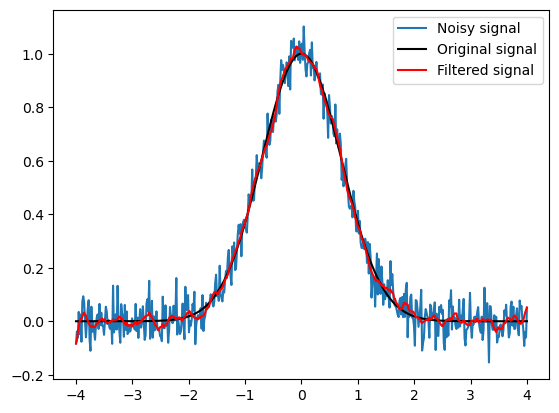

--- Time to Linearize on GPU with interpolation Cubic 1D 0.003467559814453125 seconds---


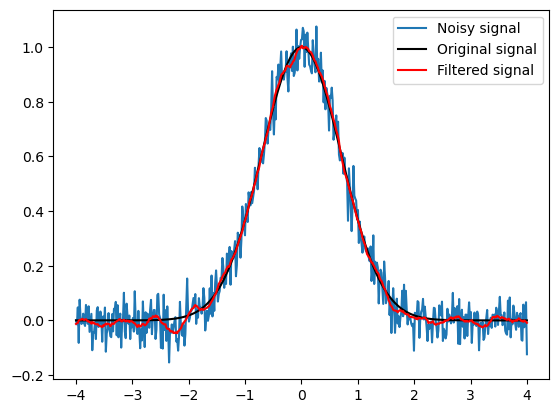

In [24]:
'Plot for CPU and execution Time'

t = np.linspace(-4, 4, 500)
y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
start=time.time()
ysg = savitzky_golay(y, window_size=31, order=4)
Time_CPU_Savgol = time.time() - start
print("--- Time to Linearize on CPU with interpolation Cubic 1D %s seconds---" % (Time_CPU_Savgol))
plt.plot(t, y, label='Noisy signal')
plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
plt.plot(t, ysg, 'r', label='Filtered signal')
plt.legend()
plt.show()


'Plot for GPU and execution Time'
t = cp.linspace(-4, 4, 500)
y = cp.exp( -t**2 ) + cp.random.normal(0, 0.05, t.shape)
start=time.time()
ysg = savitzky_golay_gpu(y, window_size=31, order=2)
Time_GPU_Savgol = time.time() - start
print("--- Time to Linearize on GPU with interpolation Cubic 1D %s seconds---" % (Time_GPU_Savgol))
y = cp.asnumpy(y)
ysg = cp.asnumpy(ysg)
t = cp.asnumpy(t)
plt.plot(t, y, label='Noisy signal')
plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
plt.plot(t, ysg, 'r', label='Filtered signal')
plt.legend()
plt.show()

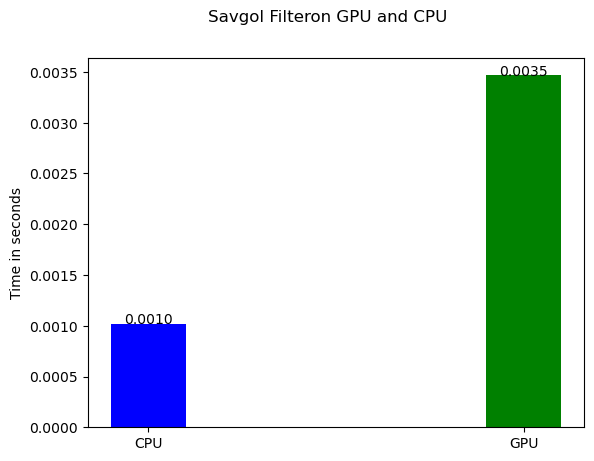

In [25]:
'Execution Time Plots for Savgol Filter'

colors=['blue', 'green']
names = ['CPU', 'GPU']
x_hist=[Time_CPU_Savgol,Time_GPU_Savgol]
x= [0,1]

plt.bar(x, x_hist, width=0.2, align='center', color=colors)
plt.xticks(x,names)
plt.ylabel('Time in seconds')
plt.suptitle('Savgol Filteron GPU and CPU')
for i in range(len(x_hist)):
        plt.text(i,x_hist[i],str("%.4f" %x_hist[i]), ha='center')
plt.show()